In [1213]:
    from collections import namedtuple
    import random
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import imutils

30908


(75, 156, 3)

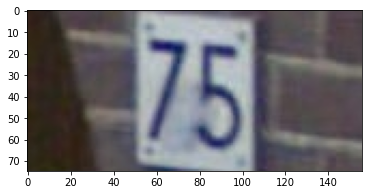

In [1214]:
i = random.randint(1,33402)
print(i)
img = cv2.imread(f'train/train/{i}.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
img.shape

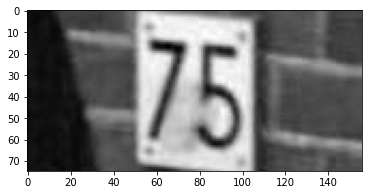

In [1215]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')


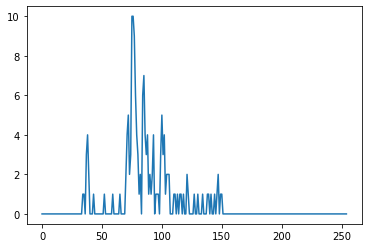

In [1216]:
hist = cv2.calcHist(gray,[0],None,[255],[0,255])
plt.plot(hist)

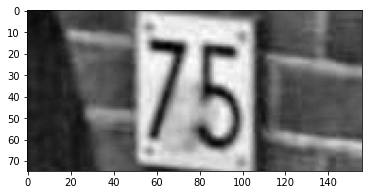

In [1290]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(5,5))
cl1 = clahe.apply(gray)
plt.imshow(cl1,cmap='gray')

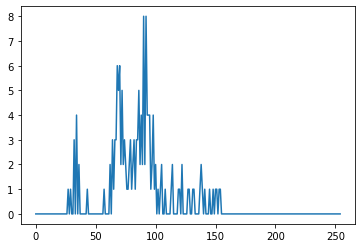

In [1291]:
hist = cv2.calcHist(cl1,[0],None,[255],[0,255])
plt.plot(hist)

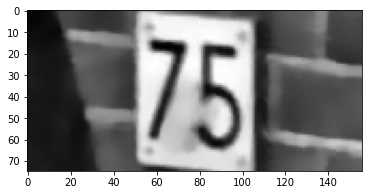

In [1292]:
bfilter= cv2.bilateralFilter(cl1,11,17,17) #Better than gaussian because it keeps edges sharp
plt.imshow(bfilter,cmap='gray')

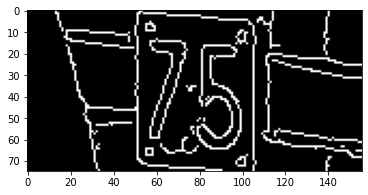

In [1293]:
edges = cv2.Canny(bfilter,30,100)
plt.imshow(edges,cmap='gray')

29

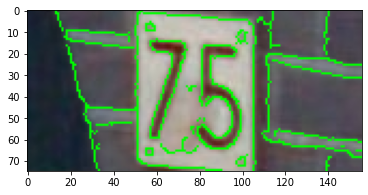

In [1294]:
keypoints= cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours=imutils.grab_contours(keypoints)
edged_cont = cv2.drawContours(img.copy(), contours, -1, (0,255,0), 1)
plt.imshow(edged_cont)
sorted_contours=sorted(contours,key=cv2.contourArea,reverse=True)
len(sorted_contours)

[[55, 6, 60, 10],
 [153, 65, 156, 66],
 [17, 9, 50, 18],
 [76, 54, 78, 58],
 [83, 40, 86, 43],
 [82, 50, 83, 52],
 [13, 0, 17, 10],
 [107, 0, 118, 18],
 [97, 9, 102, 15],
 [74, 35, 79, 38],
 [32, 52, 49, 54],
 [57, 13, 75, 60],
 [62, 59, 80, 67],
 [146, 63, 148, 64],
 [138, 0, 141, 21],
 [114, 23, 156, 32],
 [97, 67, 103, 73],
 [18, 0, 107, 75],
 [109, 20, 156, 69],
 [55, 5, 60, 10],
 [97, 68, 102, 73],
 [97, 9, 103, 16],
 [79, 50, 81, 52],
 [79, 16, 100, 65],
 [55, 64, 59, 68],
 [139, 68, 142, 75],
 [115, 55, 156, 62]]

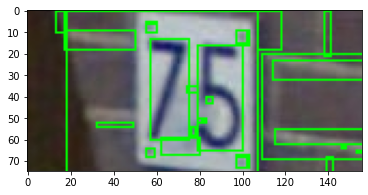

In [1276]:
pred_contours = []
pred_boxes = img.copy()
for contour in sorted_contours:
    [x, y, w, h] = cv2.boundingRect(contour)
    pred_contours.append([x, y, x+w, y+h])
    cv2.rectangle(pred_boxes, (x,y), (x+w,y+h), (0,255,0), 1)
plt.imshow(cv2.cvtColor(pred_boxes,cv2.COLOR_BGR2RGB))
pred_contours
pred_contours = [list(x) for x in set([tuple(L) for L in pred_contours])]
pred_contours

In [1277]:
digitStruct = pd.read_json('digitStruct.json')

digitStruct.set_index('filename', inplace=True)

digitStruct.head()

,boxes
filename,
1.png,"[{'height': 219.0, 'label': 1.0, 'left': 246.0..."
2.png,"[{'height': 32.0, 'label': 2.0, 'left': 77.0, ..."
3.png,"[{'height': 15.0, 'label': 2.0, 'left': 17.0, ..."
4.png,"[{'height': 34.0, 'label': 9.0, 'left': 57.0, ..."
5.png,"[{'height': 46.0, 'label': 3.0, 'left': 52.0, ..."


In [1278]:
def get_gt_contours(i):
    gt_contours = []
    boxes = digitStruct.loc[f'{str(i)}.png', 'boxes']
    for box in boxes:
        x = box['left']
        y = box['top']
        w = box['width']
        h = box['height']
        gt_contours.append([x, y, x+w, y+h])
    return gt_contours

In [1279]:
gt_contours = get_gt_contours(i)
print(len(gt_contours))
gt_contours


2


[[55.0, 11.0, 75.0, 66.0], [76.0, 11.0, 103.0, 66.0]]

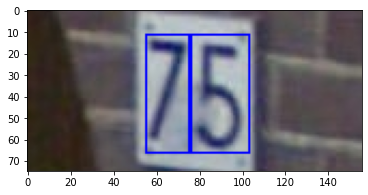

In [1280]:
gt_boxes = img.copy()
for contour in gt_contours:
    contour = list(map(int, contour)) # To cast all point values to integers (loaded from json file as float)
    [x1, y1, x2, y2] = contour
    cv2.rectangle(gt_boxes, (x1,y1), (x2,y2), (255,0,0), 1)
plt.imshow(cv2.cvtColor(gt_boxes, cv2.COLOR_BGR2RGB))

In [1281]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	
    # compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [1282]:
match_contours = []
for contour in pred_contours:
    for gt_contour in gt_contours:
        iou = bb_intersection_over_union(contour, gt_contour)
        if iou > 0.5:
            match_contours.append({'points': contour, 'iou':iou})

print(len(match_contours))
match_contours


2


[{'points': [57, 13, 75, 60], 'iou': 0.7755102040816326},
 {'points': [79, 16, 100, 65], 'iou': 0.701530612244898}]

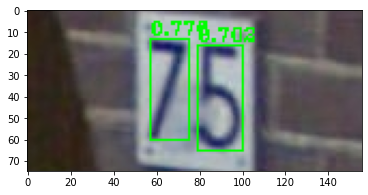

In [1283]:
match_boxes = img.copy()
for contour in match_contours:
    [x1, y1, x2, y2] = contour['points']
    cv2.rectangle(match_boxes, (x1,y1), (x2,y2), (0,255,0), 1)
    
    cv2.putText(match_boxes, "{:.3f}".format(contour['iou']), (x1, y1-2), cv2.FONT_HERSHEY_TRIPLEX, 0.3, (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(match_boxes, cv2.COLOR_BGR2RGB))